#  Modelado de Topics

**Topic Modelling** 

Conjunto de técnicas para descubrir estructuras latentes semánticas comunes (topics o temas) en un conjunto de documentos.

Consiste en identificar tópicos o temas en textos, detectando patrones en una colección de documentos "corpus" y agrupando las palabras que aparecen en los documentos.

*Topic Modelling generativo* es un modelo que permite la clasificación de documentos aún no procesados una vez que el modelo fue entrenado sin pasar por el corpus entero.

**LDA (Algoritmo Latent Dirichlet Allocation)** 

Es un modelo de topics probabilístico generativo, es decir asume que cada palabra en un documento es generada a partir de un topic que es tomado de una distribución de topics para cada documento. 

LDA permite que un documento sea parte de varios topics, cada uno con un peso diferente, es decir un documento es una distribución de topics y un topic es una distribución de palabras.

Este algoritmo asume:

- Documentos con topics similares usarán palabras similares
- Documentos compuestos por un conjunto de topics (con una determinada distribución)
- Topics compuestos por un conjunto de palabras (con una determinada distribución)

### Etapas

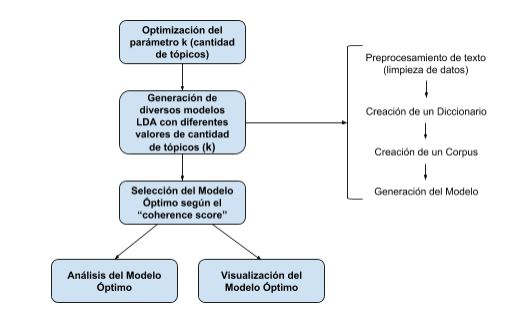

### Librerías y funciones necesarias

In [1]:
# Librería gensim (complementaria a Spacy)
# Librería pyLDAvis 
!pip install gensim
!pip install pyLDAvis

In [2]:
import random
import pandas as pd
import numpy as np

import gensim
from gensim.corpora import Dictionary  # Diccionario clave:valor
from gensim.models import LdaModel, CoherenceModel  # Modelo LDA

import pyLDAvis  # Visualizar los clusters
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Sets the value of the specified option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Función que realiza comprobaciones sobre una columna de un dataframe
def check_column(df, col_name):
    values_unique = len(df[col_name].unique())
    values_nan = df[col_name].isnull().sum()
    portmissing = round((df[col_name].isnull().sum()/len(df))*100, 4)
    
    print (f'{col_name} consta de: {values_unique} valores distintos de un total de {len(df)}')
    print (f'{col_name} consta de: {values_nan} valores ausentes, {portmissing}%')

### Lectura de datos

In [4]:
# Lectura del dataset con los reviews de amazon descargados en el notebook 0_AnalisisSentimientos_sintratamiento.ipynb
# Son 20000 tweets sobre music, clothing, health and sports con 5000 por subset balanceados por overall de 1 a 5
df_amazon = pd.read_pickle('df_amazoncompleto.pkl')
print(f'Dimensiones del dataset son: {df_amazon.shape}')

Dimensiones del dataset son: (20000, 9)


In [5]:
# Visualizamos las primeras filas
df_amazon.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A319Y60NW7HS77,B000001EGI,"radiogold ""radiogold""","[2, 21]",Tumbleweed Connection raised Elton to his init...,1.0,"Just a brief dip, he would improve again!",1084752000,"05 17, 2004"
1,A15HQSBVCU724Y,B0002XEDSU,Mikky Mouse,"[3, 4]",Im not gonna review on this.. all i can say is...,1.0,That White Tee song is retarded,1134000000,"12 8, 2005"
2,AZ39SOZT3NZQU,B000FVQYYK,XraySpex,"[4, 67]",I bought this album because I went to a lyric ...,1.0,Put This In A Black Hole,1184544000,"07 16, 2007"
3,A36489F4G8T4E7,B000075A20,Edgar Sanchez,"[5, 9]",This poorly made and horrible album is reason ...,1.0,DONT PAY THE COST FOR THIS ...,1064102400,"09 21, 2003"
4,A3NL33GFYHE72V,B0006ZQ9BS,"music fan ""music fan""","[2, 6]",This album was a big disappointment. It doesn...,1.0,NO!!!!,1106092800,"01 19, 2005"


In [6]:
# Análisis de la columna retweet
check_column(df_amazon, 'reviewText')
df_amazon['reviewText'].value_counts().head()

reviewText consta de: 19995 valores distintos de un total de 20000
reviewText consta de: 0 valores ausentes, 0.0%


In [7]:
# Análisis de la columna overall
check_column(df_amazon, 'overall')
df_amazon['overall'].value_counts().head()

overall consta de: 5 valores distintos de un total de 20000
overall consta de: 0 valores ausentes, 0.0%


5.0    4000
4.0    4000
3.0    4000
2.0    4000
1.0    4000
Name: overall, dtype: int64

In [8]:
# Nos quedamos únicamente con la columna reviewText correspondiente al review de los df de Amazon
df_amazon = df_amazon[['reviewText']]
print(f'Dimensiones del dataset son: {df_amazon.shape}')
# No es necesario porque dicha columna no contiene valores ausentes pero lo contemplo 
# para futuros procesados de otros datasets que si contengan valores ausentes.
df_amazon.dropna(inplace=True)
print(f'Dimensiones del dataset son: {df_amazon.shape}')

Dimensiones del dataset son: (20000, 1)
Dimensiones del dataset son: (20000, 1)


In [9]:
# Nos quedamos con una muestra aleatora de 2500 registros
# random_state = 1 repetitibidad en los resultados obtenidos
df_amazonfilter = df_amazon.sample(2500, random_state=1)
print(f'Dimensiones del dataset son: {df_amazonfilter.shape}')

Dimensiones del dataset son: (2500, 1)


In [10]:
# Columnas del df
df_amazonfilter.columns

Index(['reviewText'], dtype='object')

In [11]:
# Visualizamos las primeras filas y observamos que los índices corresponden a la selección aleatoria anterior
df_amazonfilter.head(3)

,reviewText
11456,The watch does do everything it says it does. ...
16528,Hatchet arrived covered in some oily substance...
3253,"Forget the plodding, Octave. THIS is the Moood..."


In [12]:
# Reset the index, or a level of it
# drop : bool, default False.   Do not try to insert index into dataframe columns. 
# This resets the index to the default integer index.
# inplace : bool, default False.  Modify the DataFrame in place (do not create a new object)
df_amazonfilter.reset_index(drop=True, inplace=True)

In [13]:
# Visualizamos las primeras filas con los índices correctos
df_amazonfilter.head(3)

,reviewText
0,The watch does do everything it says it does. ...
1,Hatchet arrived covered in some oily substance...
2,"Forget the plodding, Octave. THIS is the Moood..."


### Preprocesado

Aplicamos gensim.utils.simple_preprocess: Convert a document into a list of lowercase tokens, 

     ignoring tokens that are too short or too long.
     doc : str.     Input document.
     deacc : bool, optional.     Remove accent marks from tokens using :func:`~gensim.utils.deaccent`?
     min_len : int, optional.    Minimum length of token (inclusive). Shorter tokens are discarded.
     max_len : int, optional.    Maximum length of token in result (inclusive). Longer tokens are discarded.

In [14]:
# Función que realiza el preprocesado utilizando las librerías de gensim.utils.simple_preprocess
def text_preprocessing(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [15]:
print('Original text:\n{}\n\n'.format(df_amazonfilter['reviewText'][2]))
print('Processed text:\n{}'.format(text_preprocessing(df_amazonfilter['reviewText'][2])))

Original text:
Forget the plodding, Octave. THIS is the Mooody Blues comeback album.Most of the songs here are fantastic. The band is re-energized by the arrival of Patrick Moraz. "Talking Out Of Turn." is the best John Lodge solo vocal on any Moody Blues album from any era. "In My World" is a worthy addition to the Justin Hayward ballad catalogue. The only criticism is the Ray Thomas songs are not on par with his classic work, and, consequently, are the weakest songs on the album.


Processed text:
['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'songs', 'fantastic', 'band', 'energized', 'arrival', 'patrick', 'moraz', 'talking', 'turn', 'best', 'john', 'lodge', 'solo', 'vocal', 'moody', 'blues', 'album', 'world', 'worthy', 'addition', 'justin', 'hayward', 'ballad', 'catalogue', 'criticism', 'thomas', 'songs', 'classic', 'work', 'consequently', 'weakest', 'songs', 'album']


In [16]:
# lista de lista de documentos
processed_texts = []
for text in df_amazonfilter['reviewText']:
    processed_texts.append(text_preprocessing(text))

In [17]:
# Dimensiones del procesado de textos
len(processed_texts)

2500

In [20]:
# processed_texts[2] = text_preprocessing(df['text'][2])
print(processed_texts[2], '\n')
print('Original text:\n{}\n\n'.format(df_amazonfilter['reviewText'][2]))
print('Processed text:\n{}'.format(text_preprocessing(df_amazonfilter['reviewText'][2])))

['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'songs', 'fantastic', 'band', 'energized', 'arrival', 'patrick', 'moraz', 'talking', 'turn', 'best', 'john', 'lodge', 'solo', 'vocal', 'moody', 'blues', 'album', 'world', 'worthy', 'addition', 'justin', 'hayward', 'ballad', 'catalogue', 'criticism', 'thomas', 'songs', 'classic', 'work', 'consequently', 'weakest', 'songs', 'album'] 

Original text:
Forget the plodding, Octave. THIS is the Mooody Blues comeback album.Most of the songs here are fantastic. The band is re-energized by the arrival of Patrick Moraz. "Talking Out Of Turn." is the best John Lodge solo vocal on any Moody Blues album from any era. "In My World" is a worthy addition to the Justin Hayward ballad catalogue. The only criticism is the Ray Thomas songs are not on par with his classic work, and, consequently, are the weakest songs on the album.


Processed text:
['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'songs', 'fant

In [22]:
processed_texts[2] == text_preprocessing(df_amazonfilter['reviewText'][2])

True

### Diccionario 

In [23]:
# Función que genera un diccionario id-palabra a partir de unos textos
def get_dictionary (texts) :
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = Dictionary (texts)
    # dictionary . filter_extremes ( no_below =20 , no_above =0.5)
    # remove_n = 5 means number of the most frequent tokens that will be removed 
    dictionary.filter_n_most_frequent (5)
    return dictionary

In [24]:
# Creación de un diccionario id-palabra
dictionary = get_dictionary(processed_texts)
print(f'Longitud del diccionario: ', {len(dictionary)})

print('Diccionario id,palabra: ')
list(dictionary.items())

Longitud del diccionario:  {15663}
Diccionario id,palabra: 


[(0, 'away'),
 (1, 'bunch'),
 (2, 'certainly'),
 (3, 'controls'),
 (4, 'downloading'),
 (5, 'effort'),
 (6, 'expensive'),
 (7, 'extra'),
 (8, 'figure'),
 (9, 'friendly'),
 (10, 'hard'),
 (11, 'heart'),
 (12, 'information'),
 (13, 'instructions'),
 (14, 'interaction'),
 (15, 'interface'),
 (16, 'intuitive'),
 (17, 'iphone'),
 (18, 'know'),
 (19, 'monitor'),
 (20, 'occasional'),
 (21, 'payoff'),
 (22, 'pulling'),
 (23, 'real'),
 (24, 'running'),
 (25, 'says'),
 (26, 'software'),
 (27, 'spend'),
 (28, 'teeth'),
 (29, 'throwing'),
 (30, 'times'),
 (31, 'user'),
 (32, 'wanted'),
 (33, 'watch'),
 (34, 'watches'),
 (35, 'week'),
 (36, 'work'),
 (37, 'working'),
 (38, 'worse'),
 (39, 'worth'),
 (40, 'arrived'),
 (41, 'backpack'),
 (42, 'black'),
 (43, 'camp'),
 (44, 'cast'),
 (45, 'covered'),
 (46, 'curing'),
 (47, 'fits'),
 (48, 'hand'),
 (49, 'hands'),
 (50, 'hatchet'),
 (51, 'heavy'),
 (52, 'husband'),
 (53, 'iron'),
 (54, 'left'),
 (55, 'looked'),
 (56, 'marks'),
 (57, 'nicely'),
 (58, 'oi

### Matriz documento-palabra

In [25]:
# Función que genera un corpus dado un diccionario y unos textos
def get_corpus (dictionary, texts) :
    # convert tokenized documents into a document - term matrix
    # doc2bow (document): Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus

In [26]:
# Creación de un corpus
corpus = get_corpus(dictionary, processed_texts)
print(f'Corpus: ')
corpus

Corpus: 


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 2),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 2)],
 [(40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1)],
 [(36, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 3),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 

In [27]:
# Significa que las siguientes palabras o términos con id en el vocabulario se repiten el nº de veces indicado:
# lyrics con id 115 en el diccionario se repite 3 veces
# musicians con id 118 se repite 2 veces
print('Original  text:{}\n'.format(df_amazonfilter['reviewText'][2]))
print('Processed text:{}\n'.format(processed_texts[2]))
print('Corpus        :{}'.format(corpus[2]))


Original  text:Forget the plodding, Octave. THIS is the Mooody Blues comeback album.Most of the songs here are fantastic. The band is re-energized by the arrival of Patrick Moraz. "Talking Out Of Turn." is the best John Lodge solo vocal on any Moody Blues album from any era. "In My World" is a worthy addition to the Justin Hayward ballad catalogue. The only criticism is the Ray Thomas songs are not on par with his classic work, and, consequently, are the weakest songs on the album.

Processed text:['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'songs', 'fantastic', 'band', 'energized', 'arrival', 'patrick', 'moraz', 'talking', 'turn', 'best', 'john', 'lodge', 'solo', 'vocal', 'moody', 'blues', 'album', 'world', 'worthy', 'addition', 'justin', 'hayward', 'ballad', 'catalogue', 'criticism', 'thomas', 'songs', 'classic', 'work', 'consequently', 'weakest', 'songs', 'album']

Corpus        :[(36, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (6

Tal y como se refleja en este review, estos son algunos términos/palabras junto con el nº de veces que se repite.
    
                 id     nº veces que se repite
    band         64     1                         (64, 1)
    blues        66     2                         (66, 2)
    songs        86     3                         (86, 3)

### Entrenamiento del modelo LDA

#### Número óptimo de tokens

Para obtener el nº óptimo de topics se construyen varios modelos  LDA con diferente nº de topics (num_topics) y se toma aquel que devuelva el mayor valor de coherencia (coherence score). Este valor de coherencia es una forma simple de ver cómo de bueno es el modelo.

Pero también es cierto que para la elección de num_topics, el valor del coherence score no tiene porque ser necesariamente el más grande porque si por ejemplo se detectan las mismas palabras repetidas en muchos de los topics, esto significa que el parámetro num_topics es muy grande.



In [28]:
# Función que cálcula el valor de la coherencia entre varios modelos LDA y devuelve la lista de modelos junto con 
# la lista asociada del valor de la coherencia, de modo que podemos extraer el óptimo número de topics del modelo LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        # random_state: parameter is fundamental if you want to reproduce the training run, its like a random seed
        # passes: number of passes through the corpus during training.
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                passes=15,
                                                alpha='auto',
                                                random_state = 1)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
start_ = 1   # Nº mínimo de topics
end_   = 12  # Nº máximo de topics
step_  = 1   # Salto de 1 en 1 

# LLamada a la función compute_coherence_values para el cálculo del nº óptimo de topics 
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

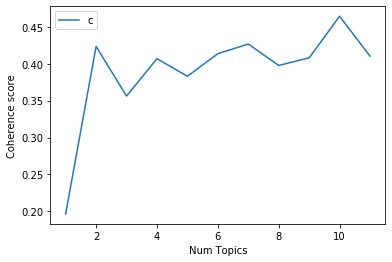

In [34]:
# Visualizamos el resultado del valor de la coherencia por cada topic
# de manera que el topic con mayor coherencia es el valor óptimo para el modelo
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " con Coherence Score: ", round(cv, 4))

Num Topics = 1  con Coherence Score:  0.1966
Num Topics = 2  con Coherence Score:  0.4235
Num Topics = 3  con Coherence Score:  0.3562
Num Topics = 4  con Coherence Score:  0.4069
Num Topics = 5  con Coherence Score:  0.383
Num Topics = 6  con Coherence Score:  0.4137
Num Topics = 7  con Coherence Score:  0.4266
Num Topics = 8  con Coherence Score:  0.3977
Num Topics = 9  con Coherence Score:  0.408
Num Topics = 10  con Coherence Score:  0.4643
Num Topics = 11  con Coherence Score:  0.4103


    Según estos resultados, aunque el óptimo num_topics es 10, podríamos optar por:
    
    - num_topic = 7 (Coherence Score:  0.4266) con posición a 6.
    
    Pero este resultado es similar con num_topics = 3 (Coherence Score:  0.4235) y como partimos de un df formado
    por reviews de Amazaon de 4 subsets, optamos por quedarnos con nº de topics a 7 y así comprobaremos si existe 
    o no solapamiento entre topics.



In [36]:
# Modelo LDA de gensim con el nº óptimo de topics seleccionados (num_topics a 12 con la posición 11)
num_topics = 7
optimal_model_id = 6

# Modelo con el óptimo nº de topics teniendo en cuenta la posición
optimal_model = model_list[optimal_model_id]

In [37]:
# Get a representation for selected topics
optimal_model.show_topics(num_topics)

[(0,
  '0.006*"rock" + 0.004*"music" + 0.004*"best" + 0.004*"arch" + 0.004*"songs" + 0.004*"kelis" + 0.003*"slash" + 0.003*"narrow" + 0.003*"long" + 0.003*"door"'),
 (1,
  '0.017*"knife" + 0.009*"blade" + 0.007*"product" + 0.005*"thumb" + 0.004*"better" + 0.004*"handle" + 0.004*"little" + 0.004*"took" + 0.003*"knives" + 0.003*"sharp"'),
 (2,
  '0.011*"light" + 0.008*"amazon" + 0.007*"product" + 0.006*"shipping" + 0.005*"work" + 0.005*"works" + 0.004*"bought" + 0.004*"quality" + 0.004*"rifle" + 0.004*"thing"'),
 (3,
  '0.010*"product" + 0.006*"work" + 0.006*"light" + 0.005*"works" + 0.005*"sure" + 0.005*"better" + 0.004*"feel" + 0.004*"tried" + 0.004*"know" + 0.004*"skin"'),
 (4,
  '0.049*"quot" + 0.011*"songs" + 0.007*"albums" + 0.007*"track" + 0.006*"love" + 0.006*"music" + 0.006*"song" + 0.005*"best" + 0.004*"tracks" + 0.004*"band"'),
 (5,
  '0.016*"size" + 0.011*"wear" + 0.009*"small" + 0.008*"little" + 0.008*"comfortable" + 0.008*"shoes" + 0.007*"look" + 0.007*"bought" + 0.007*"nic

In [38]:
# Conversión en pandas y muestra por topics las palabras o términos con mayor importancia
word_dict = {};
for i in range(num_topics):
    words = optimal_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07
0,rock,knife,light,product,quot,size,song
1,music,blade,amazon,work,songs,wear,songs
2,best,product,product,light,albums,small,music
3,arch,thumb,shipping,works,track,little,track
4,songs,better,work,sure,love,comfortable,best
5,kelis,handle,works,better,music,shoes,think
6,slash,little,bought,feel,song,look,lyrics
7,narrow,took,quality,tried,best,bought,people
8,long,knives,rifle,know,tracks,nice,love
9,door,sharp,thing,skin,band,ordered,know


In [39]:
# Visualizamos las primeras palabras clave de cada topic (ahora en horizontal) junto al peso o valor de importancia
topics = optimal_model.print_topics(num_topics=-1, num_words=5)
t = []
for topic in topics:
    t.append(topic[1].split("+"))

sent_topics_df = pd.DataFrame(data=t,columns=["word1","word2","word3","word4","word5"])
sent_topics_df

,word1,word2,word3,word4,word5
0,"0.006*""rock""","0.004*""music""","0.004*""best""","0.004*""arch""","0.004*""songs"""
1,"0.017*""knife""","0.009*""blade""","0.007*""product""","0.005*""thumb""","0.004*""better"""
2,"0.011*""light""","0.008*""amazon""","0.007*""product""","0.006*""shipping""","0.005*""work"""
3,"0.010*""product""","0.006*""work""","0.006*""light""","0.005*""works""","0.005*""sure"""
4,"0.049*""quot""","0.011*""songs""","0.007*""albums""","0.007*""track""","0.006*""love"""
5,"0.016*""size""","0.011*""wear""","0.009*""small""","0.008*""little""","0.008*""comfortable"""
6,"0.019*""song""","0.012*""songs""","0.007*""music""","0.006*""track""","0.005*""best"""


    Topic 1 - Lista de episodios The Colbert Report sobre la misión del transbordador Atlantis 
        {happy - Equator - North - mathematics - Colbert - Atlantis - sunrise - 
         March - months - world - inch}
        
    Topic 2 - podría estar relacionado con una película sobre los secretos del universo:
        {Pluto - scientistis - Mars - posted - secret - film - America - interested - 
         energy - nova (canal de televisión/ explosión termonuclear)
 
    Topic 3 - no detecto un topic con las palabras incluidas 
    Topic 4 - no detecto un topic con las palabras incluidas  
    Topic 5 - no detecto un topic con las palabras incluidas 
    Topic 6 - no detecto un topic con las palabras incluidas 
    
    Topic 7 - podría tener que ver con un tweet sobre las misiones a Marte de la NASA:
        {horizon - space - shuttle - Nasa - Mars - illusion - future - number - book - launch}
        
    Topic 8 -  referencia al libro "In Defense of Science: Why Scientific Literacy Matters"
        {things - plus - Isaac Newton - world - hard - good - tree - land - minds - 
         questions - state - ghostbusters - laws - head - letters}
         
    Topic 9 -  tweet con referencias al libro "Death by Black Hole: And Other Cosmic Quandaries"
       {black - years - death - hole - blue - asteroid - humans - calendar - mountains - cosmos}
    
    Topic 10 - tweet con referencias al libro "One Universe: At Home in the Cosmos"
        {year - world - space - Tyson - bowl - star - Newton - universe -
         experiment - molecules - plan - train - angle - baseball}
        
    Topic 11 - relacionados con detalles de planetas:
        {Pluto - universe - speed - Saturn - geek - aliens - files - live - mass}
        
    Topic 12 - tweet sobre Manhattanhenge, espectacular puesta de sol considerada como un evento astronómico que tiene 
    lugar únicamente dos veces al año, durante los meses de Mayo y Julio.
    Se produce cuando el Sol se alinea durante el amanecer en algunas de las calles que forman una cuadrícula en la 
    isla de Manhattan (Nueva York) 
        {star - Venus - night - tweet - twilight - crescent - planet - Manhattanhence - parts}
        

Con lo cual, según este análisis de los 12 topics, sólo encuento con sentido en 8 topics: 
    
    Topic 1 - Lista de episodios The Colbert Report sobre la misión del transbordador Atlantis      
    Topic 2 - podría estar relacionado con una película sobre los secretos del universo:
    Topic 7 - podría tener que ver con un tweet sobre las misiones a Marte de la NASA:       
    Topic 8 -  referencia al libro "In Defense of Science: Why Scientific Literacy Matters"         
    Topic 9 -  tweet con referencias al libro "Death by Black Hole: And Other Cosmic Quandaries"    
    Topic 10 - tweet con referencias al libro "One Universe: At Home in the Cosmos"        
    Topic 11 - relacionados con detalles de planetas (Pluto y Saturn)        
    Topic 12 - tweet sobre Manhattanhenge

### Calidad del modelo

#### Perplexity y Coherence Score 

In [40]:
# Perplexity # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  

# Coherence Score del id del óptimo num_topics seleccionadoeste dato ya esta calculado en los apartados anteriores)
print('\nCoherence Score: ', coherence_values[optimal_model_id])


Perplexity:  -8.709848301624923

Coherence Score:  0.42664281363412965


### Visualización del modelo

In [41]:
# Enable the automatic display of visualizations in the IPython Notebook.
pyLDAvis.enable_notebook()
# Transforms the Gensim TopicModel and related corpus and dictionary into the data structures needed for the visualization
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.149363 -0.090406       1        1  26.352898
3     -0.098026 -0.075428       2        1  17.686836
5     -0.107107 -0.056174       3        1  17.154772
4      0.221095 -0.043508       4        1  13.552143
2     -0.147490  0.006472       5        1  10.816446
1     -0.090870  0.050351       6        1   9.243600
0      0.073036  0.208695       7        1   5.193300, topic_info=      Category        Freq           Term       Total  loglift  logprob
660    Default  683.000000           quot  683.000000  30.0000  30.0000
158    Default  600.000000           song  600.000000  29.0000  29.0000
86     Default  497.000000          songs  497.000000  28.0000  28.0000
243    Default  311.000000           size  311.000000  27.0000  27.0000
831    Default  162.000000          knife  162.000000  26.0000  26.0000
444    Default  202.000000           wear  202.000000  25.0000  25.0000
217    Default  356.000000        product  356.000000  24.0000  24.0000
143    Default  291.000000          music  291.000000  23.0000  23.0000
664    Default  145.000000    comfortable  145.000000  22.0000  22.0000
957    Default  290.000000          light  290.000000  21.0000  21.0000
389    Default  245.000000          track  245.000000  20.0000  20.0000
593    Default  147.000000          shoes  147.000000  19.0000  19.0000
670    Default  160.000000         albums  160.000000  18.0000  18.0000
814    Default   90.000000          blade   90.000000  17.0000  17.0000
693    Default  135.000000           rock  135.000000  16.0000  16.0000
219    Default  221.000000          small  221.000000  15.0000  15.0000
716    Default  169.000000         tracks  169.000000  14.0000  14.0000
838    Default  133.000000        ordered  133.000000  13.0000  13.0000
865    Default  136.000000         amazon  136.000000  12.0000  12.0000
109    Default  184.000000          works  184.000000  11.0000  11.0000
877    Default   64.000000       shipping   64.000000  10.0000  10.0000
140    Default  166.000000         lyrics  166.000000   9.0000   9.0000
756    Default  246.000000         bought  246.000000   8.0000   8.0000
242    Default   87.000000           shoe   87.000000   7.0000   7.0000
999    Default  145.000000          sound  145.000000   6.0000   6.0000
65     Default  325.000000           best  325.000000   5.0000   5.0000
193    Default   68.000000          shave   68.000000   4.0000   4.0000
647    Default   77.000000           skin   77.000000   3.0000   3.0000
181    Default   66.000000           hair   66.000000   2.0000   2.0000
68     Default  109.000000        classic  109.000000   1.0000   1.0000
1943    Topic1   59.544537         eminem   60.248554   1.3218  -6.1147
1774    Topic1   49.912094           game   51.077095   1.3105  -6.2912
5523    Topic1   28.985659          crazy   29.687346   1.3097  -6.8346
1514    Topic1   28.336164          elton   29.046959   1.3088  -6.8573
1806    Topic1   25.662760          sings   26.384964   1.3058  -6.9564
7993    Topic1   24.722946           dope   25.425386   1.3056  -6.9937
4249    Topic1   24.195292        hendrix   24.897676   1.3050  -7.0153
87      Topic1   23.874998        talking   24.576670   1.3046  -7.0286
4057    Topic1   42.534428      featuring   43.895500   1.3021  -6.4511
7297    Topic1   21.859432        whitney   22.559526   1.3021  -7.1168
3717    Topic1   21.424612         genius   22.129847   1.3012  -7.1369
1683    Topic1   23.256222           club   24.027851   1.3010  -7.0549
469     Topic1   20.154112          nelly   20.854557   1.2994  -7.1980
1340    Topic1   25.528631         rapper   26.441288   1.2985  -6.9616
10462   Topic1   18.452330       jennifer   19.152393   1.2964  -7.2862
456     Topic1   18.942329           cent   19.669395   1.2959  -7.2600
8992    Topic1   17.919855         hudson   18.619925   1.2953  -7.3155
715     Topic1 

In [42]:
pyLDAvis.save_html(vis, '../notebooks/results/topics_reviewsamazon_n7.html')

Cada burbuja en la parte izquierda representa un topic. 

Cuanto más grande la burbuja, más predominante es ese topi. En nuestra representación y según el apartado final "Distribución de topics en el corpus", los topics con menor distribución son los nº 6 y 1 que están asociados a las burbujas 11 y 12 respectivamente y que efectivamente su tamaño es algo menor.

Mapeo entre burbujas y topics:

    Burbuja 1  representa el Topic nº 7  (tweet sobre las misiones a Marte de la NASA)
    Burbuja 2  representa el Topic nº 3
    Burbuja 3  representa el Topic nº 9  (tweet con referencias al libro "Death by Black Hole: And Other Cosmic Quandaries")
    Burbuja 4  representa el Topic nº 4
    Burbuja 5  representa el Topic nº 8  (tweey con referencias al libro "In Defense of Science: Why Scientific Literacy Matters")
    Burbuja 6  representa el Topic nº 2  (tweet de una película sobre los secretos del universo)
    Burbuja 7  representa el Topic nº 12 (tweet sobre Manhattanhenge)
    Burbuja 8  representa el Topic nº 11 (relacionados con detalles de planetas Plutón y Saturno) 
    Burbuja 9  representa el Topic nº 5
    Burbuja 10 representa el Topic nº 10 (tweet con referencias al libro "One Universe: At Home in the Cosmos")
    Burbuja 11 representa el Topic nº 6
    Burbuja 12 representa el Topic nº 1  (The Colbert Report sobre la misión del transbordador Atlantis)

Si posicionamos el cursor sobre una burbuja, las palabras y el gráfico de la derecha se actualizan y estas palabras son las palabras clave más importantes para el topic asociado a dicha burbuja.

Algunas burbujas que se solapan como 3 y 9, o 7, 10 y 11, o, 1 y 2, o 5 y 12 porque compartes las mismas palabras.
Si seleccionamos una palabra del gráfico de barras, observamos las burbujas en las cuales aparece por orden de importancia según el tamaño de la(s) burbuja(s)

### Topic dominante por texto

In [43]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [45]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=processed_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4829,"light, amazon, product, shipping, work, works,...","[watch, says, like, pulling, teeth, interface,..."
1,1,3.0,0.7563,"light, amazon, product, shipping, work, works,...","[hatchet, arrived, covered, oily, substance, s..."
2,2,5.0,0.4813,"quot, songs, albums, track, love, music, song,...","[forget, plodding, octave, mooody, blues, come..."
3,3,2.0,0.4692,"knife, blade, product, thumb, better, handle, ...","[room, cleaning, guns, little, fuzzy, surface,..."
4,4,7.0,0.8513,"song, songs, music, track, best, think, lyrics...","[reason, gave, stars, like, took, emotion, sor..."
5,5,4.0,0.9889,"product, work, light, works, sure, better, fee...","[start, saying, better, quality, epilators, wi..."
6,6,3.0,0.9638,"light, amazon, product, shipping, work, works,...","[striper, clips, work, great, wanted, bend, wo..."
7,7,2.0,0.9727,"knife, blade, product, thumb, better, handle, ...","[good, product, emitting, fragrant, smell, pur..."
8,8,6.0,0.5877,"size, wear, small, little, comfortable, shoes,...","[foot, size, order, true, stretch, material, e..."
9,9,6.0,0.5209,"size, wear, small, little, comfortable, shoes,...","[looked, like, picture, smelled, funny, wanted..."


    Para el documento nº 1 --> topic dominante es el nº 7 tweet sobre las misiones a Marte de la NASA
    Para el documento nº 3 --> topic dominante es el nº 11 relacionado con detalles de planetas Plutón y Saturno
    Para el documento nº 4 y 9 --> topic dominante es el nº 10 con referencias al libro "One Universe: At Home in the Cosmos")
    Para el documento nº 5 --> topic dominante es el nº 2 tweet de una película sobre los secretos del universo
    Para el documento nº 7 --> topic dominante es el nº 2 tweet con referencias al libro "Death by Black Hole: And Other Cosmic Quandaries"

### Documento más representativo por topic

In [46]:
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([
        sent_topics_sorteddf_lda,
        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
        axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_lda

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.9959,"rock, music, best, arch, songs, kelis, slash, ...","[mientras, grupos, ingleses, mediados, redescu..."
1,2.0,0.9925,"knife, blade, product, thumb, better, handle, ...","[getting, tool, having, trouble, getting, cont..."
2,3.0,0.9934,"light, amazon, product, shipping, work, works,...","[hydracentials, water, bottle, tall, narrow, d..."
3,4.0,0.9972,"product, work, light, works, sure, better, fee...","[tend, prefer, rotary, shavers, foil, usual, w..."
4,5.0,0.9966,"quot, songs, albums, track, love, music, song,...","[albums, disc, collection, contains, long, ver..."
5,6.0,0.9953,"size, wear, small, little, comfortable, shoes,...","[fabric, felt, great, silky, smooth, wonderful..."
6,7.0,0.9983,"song, songs, music, track, best, think, lyrics...","[look, loved, limp, bizkit, like, limp, bizkit..."


### Distribución de topics en el corpus

In [47]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), num_topics)
df_topic_contribution = pd.DataFrame({'topic': topic_contribution.index, 'contribution': topic_contribution})
df_topic_contribution.reset_index(drop=True, inplace=True)

# Show
df_topic_contribution

,topic,contribution
0,6.0,0.2952
1,4.0,0.1904
2,7.0,0.1840
3,3.0,0.1276
4,2.0,0.0896
5,5.0,0.0812
6,1.0,0.0320


### Conclusiones

A partir de un dataset de tweets se ha aplicado la técnica topic modeling para la detección de los principales topics o temas, a los cuales referencian los usuarios desde la red y cuya interpretabilidad puede que sea bastante subjetiva por mi parte.
